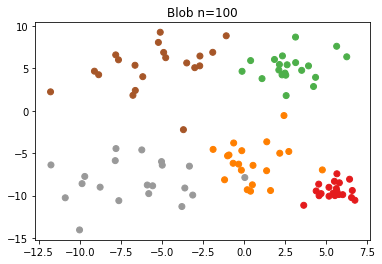

In [77]:
from functools import reduce
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
import numpy as np
import math
import time

n_samples = 100
blobs,label = datasets.make_blobs(n_samples=n_samples,centers=5, random_state=10,cluster_std=[0.9,1.5,2.0,2.5,3])
data = np.array(blobs)

lbd = 0.1
delta = 1e-4
Lip = 1 + len(data) * lbd / delta
alpha = 1 / Lip
d = 2
n = n_samples
X = np.zeros((n,d))  #initial value


plt.scatter(data[:,0],data[:,1],c=label, cmap='Set1')
plt.title(f'Blob n={n_samples}')
plt.show()

In [78]:

def f(x):
    x = x.reshape((n, d))
    hg_1 = []
    for i in range(len(x)):
        x_1 = x[i, :] - x
        norm_x = np.linalg.norm(x_1, ord=2, axis=1, keepdims=True)
        hub_mat_1 = norm_x**2 / (2 * delta)
        hub_mat_2 = norm_x - 0.5 * delta
        hub_mat = np.where(norm_x > delta, hub_mat_2, hub_mat_1)
        hg_1.append(hub_mat[i:].sum())
    return (lbd * np.array(hg_1).sum() + np.linalg.norm(x-data, axis=1).sum()*0.5).flatten(order='A')


def hub_grad2(x, delta=1e-4):
    x = x.reshape((n, d))
    hg_1 = np.zeros((n, d))
    for i in range(len(x)):
        x_1 = x[i, :] - x
        norm_x = np.linalg.norm(x_1, ord=2, axis=1, keepdims=True)
        norm_x = np.where(norm_x > delta, norm_x, delta)
        x_1a = x_1 / norm_x
        x_1a = x_1a.sum(axis=0)
        hg_1[i, :] = lbd * x_1a
    return (hg_1 + x - data).flatten(order='A')


In [79]:

def BBstep_1(x, maxit=1000):
    tol = 1e-4
    xk = x
    BB_min = 1e-8
    BB_max = 10  
    alpha = 1 / Lip #初始
    FDiff = math.inf
    XDiff = math.inf
    maxit = 0
    while True:

        nrmG = np.linalg.norm(hub_grad2(xk).reshape((n, d)), ord=2)

        if nrmG <= tol or (FDiff < tol and XDiff < tol) or maxit>1000: 
            break
        #当数据量增大，要求同样的tol会变得越来越难

        # Zhang & Hager
        c = f(xk)
        beta = 0.5
        nls = 1
        q = 1
        while True:
            xk_new = xk - alpha * hub_grad2(xk)            
                       
            cond_l = f(xk_new)
            cond_r = c - 0.5 * alpha * np.linalg.norm(hub_grad2(xk).reshape((n,d)), ord=2)**2
            # print('condtion, cond_l: ', cond_l, "cond_r: ", cond_r, 'cond_l<cond_r: ', cond_l<cond_r, 'alpha: ',alpha )

            if cond_l < cond_r or nls > 10: 
                # if cond_l < cond_r: print("True")
                break
            
            nls += 1
            alpha = beta * alpha
            q_new = 0.005 * q + 1            
            c = (0.005 * q * c + f(xk_new)) / q_new

            q = q_new

        xk_new = xk - alpha * hub_grad2(xk)
        FDiff = abs(f(xk) - f(xk_new)) / (abs(f(xk)) + 1)
        XDiff = np.linalg.norm((xk_new - xk).reshape((n,d)), ord=2) / n**2

        #BB
        sk_1 = xk_new - xk
        yk_1 = hub_grad2(xk_new) - hub_grad2(xk)       

        numerator = sk_1.T.dot(yk_1)        
        denominator = yk_1.T.dot(yk_1)
        alpha = numerator / denominator 
        
        if numerator == 0: alpha = 1 / Lip
        
        alpha = max(min(alpha, BB_max), BB_min) #截断
        
        maxit += 1
       
        xk = xk_new
    # print('ALPHA: ', alpha, "1/LIP: " ,1/Lip)
    return alpha

In [80]:
def agm(x0, tol, maxit=20000, **option):
    """
    Accelerated Gradient method
    """
    xk = x0.flatten(order='A')
    norm = np.zeros(maxit)  #store the norm of gk
    norm[0] = np.linalg.norm(hub_grad2(xk).reshape((n, d)), ord=2)
    y = xk
    alpha = 1 / Lip
    tk_1 = 1
    tk = 1
    # print("----Accelerated Gradient Method----")
    # print('ITER ;   G.NORM')
    for i in range(1, maxit):
        # alpha = BBstep_1(xk)
        ng = norm[i - 1]
        if ng <= tol:
            break
        xk, xk_1 = y - alpha * hub_grad2(y), xk
        norm[i] = np.linalg.norm(hub_grad2(xk).reshape((n, d)), ord=2)
        # print(i, ng)
        tk, tk_1 = 0.5 * (1 + math.sqrt(1 + 4 * tk_1 ** 2)), tk
        beta = (tk_1 - 1) / tk
        y = xk + beta * (xk - xk_1)
    # print("Local Minimizer x =", xk)
    norm = norm[0: i]
    return [xk.reshape((n, d)), norm]


def agm_BB(x0, tol, maxit=20000, **option):
    """
    Accelerated Gradient method
    """
    xk = x0.flatten(order='A')
    norm = np.zeros(maxit)  #store the norm of gk
    norm[0] = np.linalg.norm(hub_grad2(xk).reshape((n, d)), ord=2)
    y = xk
    alpha = 1 / Lip
    tk_1 = 1
    tk = 1
    # print("----Accelerated Gradient Method with BB----")
    # print('ITER ;   G.NORM')
    for i in range(1, maxit):
        alpha = BBstep_1(xk) #The only difference between 2 functions
        ng = norm[i - 1]
        if ng <= tol:
            break
        xk, xk_1 = y - alpha * hub_grad2(y), xk
        norm[i] = np.linalg.norm(hub_grad2(xk).reshape((n, d)), ord=2)
        # print(i, ng)
        tk, tk_1 = 0.5 * (1 + math.sqrt(1 + 4 * tk_1 ** 2)), tk
        beta = (tk_1 - 1) / tk
        y = xk + beta * (xk - xk_1)
    # print("Local Minimizer x =", xk)
    norm = norm[0: i]
    return [xk.reshape((n, d)), norm]

In [89]:
T1 = time.time()
result = agm(X,tol=1e-3)
T2 = time.time()
print(f"training time on simple AGM on dataset n={n_samples}: {((T2 - T1)*1000):.0f}ms")
print(f"The corresponding number of iteration: {len(result[1])}")

training time on simple AGM on dataset n=100: 22625ms
The corresponding number of iteration: 3668


In [86]:
T1 = time.time()
result_BB = agm_BB(X,tol=1e-3)
T2 = time.time()
print(f"Training time on AGM with BB step size on dataset n={n_samples}: {((T2 - T1)*1000):.0f}ms")
print(f"The corresponding number of iteration: {len(result_BB[1])}")

Training time on AGM with BB step size on dataset n=100: 84781ms
The corresponding number of iteration: 1686


Dendrogram should be approaximately the same

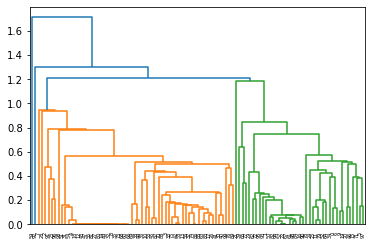

In [90]:
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
X_opt = result[0]
dis = linkage(X_opt, method='single', metric='euclidean')

X_opt_BB = result_BB[0]
dis_BB = linkage(X_opt_BB, method='single', metric='euclidean')

dendrogram(dis)
plt.show()


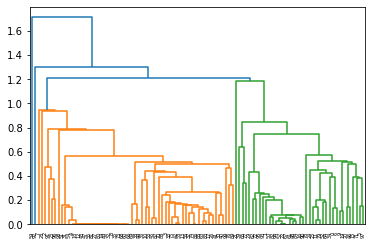

In [91]:
dendrogram(dis_BB)
plt.show()

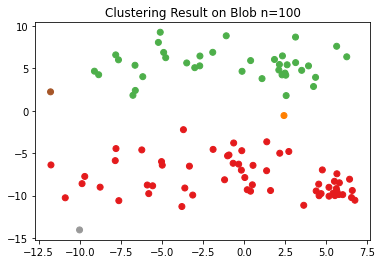

In [94]:
label2 = fcluster(dis_BB, t=1.1, criterion='distance')

plt.scatter(data[:,0],data[:,1],c=label2,cmap='Set1')
plt.title(f'Clustering Result on Blob n={n_samples}')
plt.show()

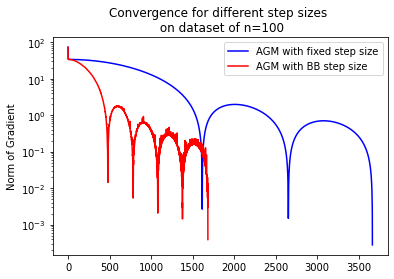

In [95]:
plt.figure(figsize=(6,4))
plt.plot(range(0, len(result[1])), result[1],'b', label = 'AGM with fixed step size')
plt.plot(range(0, len(result_BB[1])), result_BB[1],'b', c='r', label = 'AGM with BB step size')
plt.yscale('log')
plt.legend()
plt.ylabel("Norm of Gradient")
plt.title(f'Convergence for different step sizes \n on dataset of n={n_samples}')
#plt.ylim(ymin=10**(-5))
#plt.xlim((0,1000))
plt.show()